In [1]:
#open the train.txt file as a pandas dataframe, where the first column is the source node, the second column is the final node and the third column is the edge
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.svm import SVC
import json


with open('facebook_large\musae_facebook_features.json', 'r') as file:
    features_dict = json.load(file)



#open the df file with columns as id_1 and id_2
df= pd.read_csv('facebook_large\musae_facebook_edges.csv', header=0)


#open the node_informations.csv file
final = pd.read_csv('facebook_large\musae_facebook_target.csv', header=0)



# Exploratory Data Analysis and Feature Engineering

In [2]:
df.head()

,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829


In [3]:
final.head()

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician


In [4]:
print(final.shape)
print(df.shape)

(22470, 4)
(171002, 2)


Creating a NetworkX graph to compute various properties of nodes

In [5]:

# Create the graph from the DataFrame
G = nx.from_pandas_edgelist(df, 'id_1', 'id_2')

Degree

In [6]:
degrees = dict(G.degree())
print(degrees)

{0: 1, 18427: 51, 1: 34, 21708: 195, 22208: 205, 22171: 330, 6829: 27, 16590: 87, 20135: 140, 8894: 52, 15785: 147, 10281: 13, 22265: 226, 7136: 25, 22405: 41, 10379: 468, 13737: 62, 8533: 36, 14344: 50, 2812: 45, 5755: 68, 16260: 26, 15026: 42, 17370: 193, 17460: 66, 8049: 193, 5307: 122, 4987: 99, 18304: 25, 12305: 67, 19743: 678, 20024: 128, 21729: 659, 10554: 56, 11557: 72, 5228: 64, 9934: 71, 2: 12, 9048: 14, 6353: 23, 2629: 2, 11537: 22, 13205: 20, 22304: 20, 17728: 9, 19337: 14, 126: 23, 17554: 11, 8495: 17, 5857: 11, 3: 10, 16742: 21, 293: 59, 5826: 36, 3479: 22, 19753: 32, 17346: 15, 10945: 46, 22338: 46, 11319: 14, 9654: 8, 4: 51, 13645: 65, 20876: 32, 11446: 22, 16203: 56, 2830: 20, 2004: 37, 20624: 38, 21280: 47, 1182: 32, 21538: 26, 1443: 71, 11423: 29, 187: 142, 5730: 16, 2983: 35, 1489: 22, 6823: 43, 17695: 112, 11102: 158, 6390: 64, 17242: 20, 10018: 32, 5147: 31, 6427: 41, 14628: 70, 1882: 30, 22401: 33, 16128: 61, 12872: 69, 9263: 55, 14155: 32, 21631: 71, 6329: 21, 1

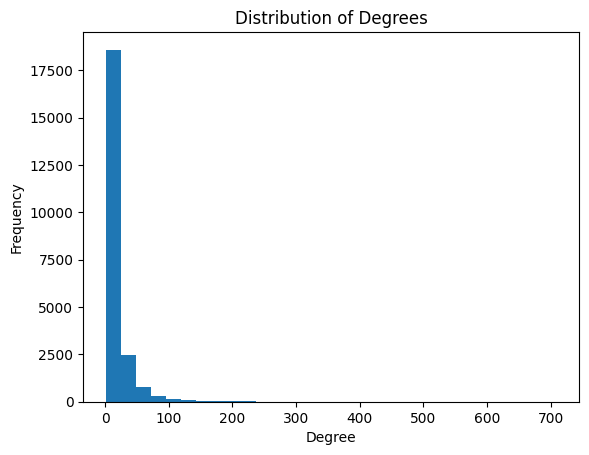

In [7]:
#plot distribution of degrees

# Get the degrees from the dictionary
degree_values = list(degrees.values())

# Plot the distribution
plt.hist(degree_values, bins=30)
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Distribution of Degrees')
plt.show()


In [8]:
#plot minimum, maximum and average degree
print('Minimum degree:', min(degree_values))
print('Maximum degree:', max(degree_values))
print('Average degree:', sum(degree_values) / len(degree_values))

Minimum degree: 1
Maximum degree: 709
Average degree: 15.220471740097908


In [9]:

final['degree'] = final['id'].map(degrees)
final.head()

#find number of null values in the degree column

print(final['degree'].isnull().sum())

#find number of 0 values in the degree column
print(final[final['degree'] == 0].shape)

0
(0, 5)


In [10]:
#find different values which page_type column can take
final['page_type'].value_counts()

government    6880
company       6495
politician    5768
tvshow        3327
Name: page_type, dtype: int64

Degree Centrality

In [11]:
#Compute degree centrality for each node and store it in final dataframe
degree_centrality = nx.degree_centrality(G)
final['degree_centrality'] = final['id'].map(degree_centrality)

Text(0.5, 1.0, 'Distribution of Degree Centrality')

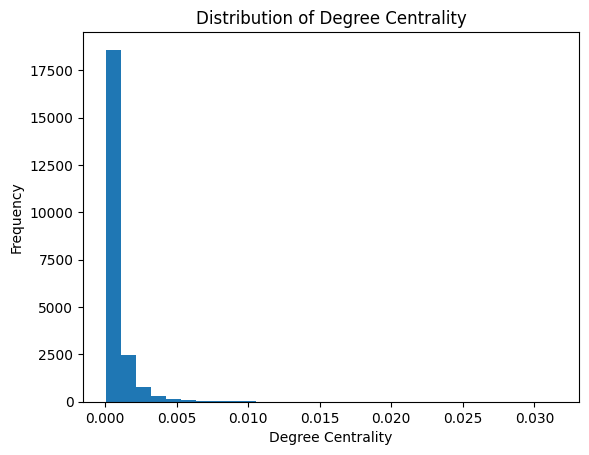

In [12]:
#plot the degree centrality distribution
plt.hist(list(degree_centrality.values()), bins=30)
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.title('Distribution of Degree Centrality')

For each node: Find number of neighbor nodes it is linked to which are politicians, government, company and tvshow

In [13]:
#rename the page type values to numbers
final['page_type'] = final['page_type'].map({'government': 0, 'politician': 1, 'company': 2, 'tvshow': 3})

In [14]:
#create 4 new columns, one for each page_type 
final['government'] = 0
final['politician'] = 0
final['company'] = 0
final['tvshow'] = 0


In [15]:
#for each id, find all its neighbors and update the corresponding page_type column
for i in final.index:
    neighbors = list(G.neighbors(final.loc[i, 'id']))
    for neighbor in neighbors:
        if final.loc[neighbor, 'page_type'] == 0:
            final.loc[i, 'government'] += 1
        elif final.loc[neighbor, 'page_type'] == 1:
            final.loc[i, 'politician'] += 1
        elif final.loc[neighbor, 'page_type'] == 2:
            final.loc[i, 'company'] += 1
        elif final.loc[neighbor, 'page_type'] == 3:
            final.loc[i, 'tvshow'] += 1

In [16]:
final.head()

,id,facebook_id,page_name,page_type,degree,degree_centrality,government,politician,company,tvshow
0,0,145647315578475,The Voice of China 中国好声音,3,1,0.000045,0,0,0,1
1,1,191483281412,U.S. Consulate General Mumbai,0,34,0.001513,32,0,2,0
2,2,144761358898518,ESET,2,12,0.000534,0,0,12,0
3,3,568700043198473,Consulate General of Switzerland in Montreal,0,10,0.000445,7,2,1,0
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,1,51,0.002270,3,41,1,6


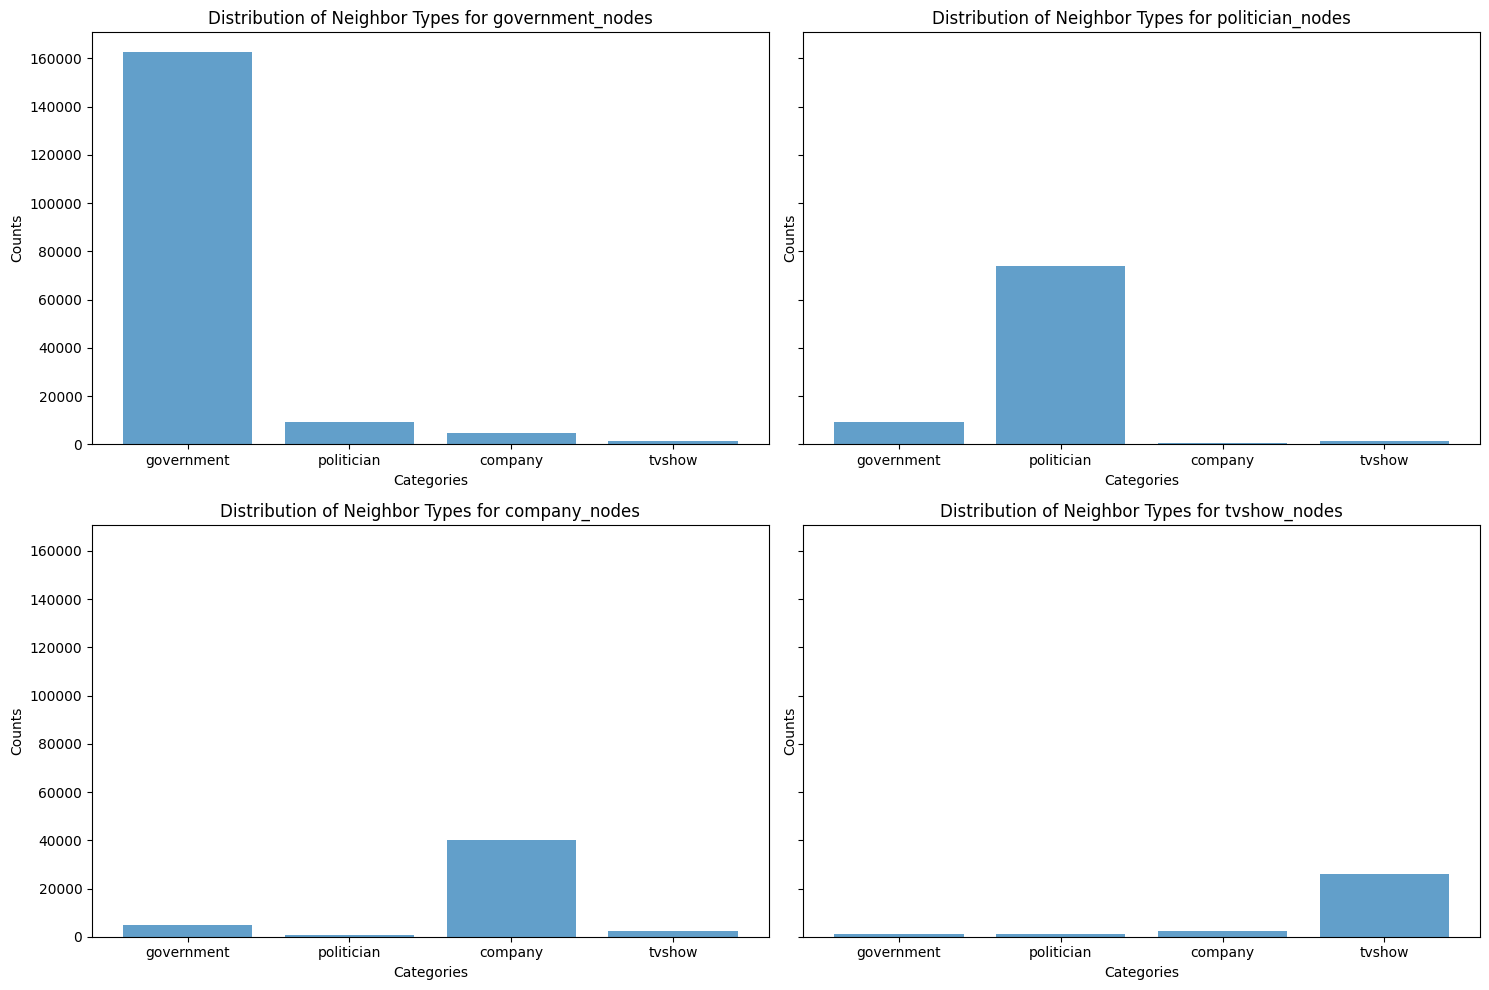

In [18]:


# Assume 'final' DataFrame has been correctly prepared beforehand
government_data = final[final['page_type'] == 0]
politician_data = final[final['page_type'] == 1]
company_data = final[final['page_type'] == 2]
tvshow_data = final[final['page_type'] == 3]

# Prepare the data
categories = ['government', 'politician', 'company', 'tvshow']
page_types = ['government_data', 'politician_data', 'company_data', 'tvshow_data']
data = {
    'government_nodes': government_data[categories].sum(),
    'politician_nodes': politician_data[categories].sum(),
    'company_nodes': company_data[categories].sum(),
    'tvshow_nodes': tvshow_data[categories].sum(),
}

# Set up the bar chart
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharey=True)

# Flatten the axes array
axes_flat = axes.flatten()

# Number of categories
n_categories = len(categories)

# Create bar chart for each page type
for ax, (page_type, counts) in zip(axes_flat, data.items()):
    # Create bar locations
    bar_locations = np.arange(n_categories)
    
    # Create a bar chart
    ax.bar(bar_locations, counts, align='center', alpha=0.7)
    
    # Set the title of the subplot
    ax.set_title(f'Distribution of Neighbor Types for {page_type}')
    
    # Set the ticks to be the name of the categories
    ax.set_xticks(bar_locations)
    ax.set_xticklabels(categories)
    
    # Set the common labels
    ax.set_ylabel('Counts')
    ax.set_xlabel('Categories')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## Incorporating Node Feature Information

In [ ]:


# Prepare a DataFrame for the features
# Initialize a dictionary with an entry for each keyword set to 0
all_keywords = set()
for keywords in features_dict.values():
    all_keywords.update(keywords)

# Initialize your features DataFrame with zeros
keywords_df = pd.DataFrame(0, index=features_dict.keys(), columns=all_keywords)

# Fill the DataFrame: set 1 where the keyword is present
for id, keywords in features_dict.items():
    keywords_df.loc[id, keywords] = 1

# Reset the index so you have an 'id' column to merge on
keywords_df.reset_index(inplace=True)
keywords_df.rename(columns={'index': 'id'}, inplace=True)

# Convert 'id' to integer for both DataFrames
final['id'] = final['id'].astype(int)
keywords_df['id'] = keywords_df['id'].astype(int)

# Merge the DataFrames on the 'id' column
final = pd.merge(final, keywords_df, on='id', how='left')


In [ ]:
final.head()

,id,page_type,degree,government,politician,company,tvshow,0,1,2,...,4704,4705,4706,4707,4708,4709,4710,4711,4712,4713
0,0,3,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,34,32,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,12,0,0,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,3,0,10,7,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,51,3,41,1,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
keyword_column_names = [final.columns[i] for i in all_keywords]
#drop the ('id','degree','page_type','government','politician','company','tvshow') column from keyword_column_names
keyword_column_names = keyword_column_names[7:]
final.columns = final.columns.astype(str)
print(keyword_column_names)
#convert the keyword_column_names to string
keyword_column_names = [str(i) for i in keyword_column_names]


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '15

# MODELS

## SVC

Testing SVC with only Neighbor Information

In [ ]:


# Define the features and target variables
features = ['degree', 'government', 'politician', 'company', 'tvshow','degree_centrality']
target = 'page_type'
X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Split the data into training and testing sets

# Create the SVM classifier model
model = SVC()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred = model.predict(X_test)


In [ ]:

print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9483756119270138
Confusion Matrix:
[[1296   41   19    2]
 [  46 1073    2    4]
 [  33    2 1285   20]
 [   9    9   45  608]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1358
           1       0.95      0.95      0.95      1125
           2       0.95      0.96      0.96      1340
           3       0.96      0.91      0.93       671

    accuracy                           0.95      4494
   macro avg       0.95      0.94      0.95      4494
weighted avg       0.95      0.95      0.95      4494



Testing the SVC model with both Node Features as Well as Neighbor Information

In [ ]:

# Define the features and target variables
features = keyword_column_names + ['degree', 'government', 'politician', 'company', 'tvshow']
target = 'page_type'
X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Split the data into training and testing sets

# Create the SVM classifier model
model = SVC()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred = model.predict(X_test)


In [ ]:
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9821984868713841
Confusion Matrix:
[[1343   14    1    0]
 [  22 1101    1    1]
 [   6    6 1316   12]
 [   1    1   15  654]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1358
           1       0.98      0.98      0.98      1125
           2       0.99      0.98      0.98      1340
           3       0.98      0.97      0.98       671

    accuracy                           0.98      4494
   macro avg       0.98      0.98      0.98      4494
weighted avg       0.98      0.98      0.98      4494



## CatBoost

Testing CatBoost with only Node Information

In [ ]:

#Create catboost model to predict the page_type using just Node Information

features = keyword_column_names
target = 'page_type'

X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Create the CatBoost classifier model
model = CatBoostClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred=model.predict(X_test)

Learning rate set to 0.091688
0:	learn: 1.3197497	total: 173ms	remaining: 2m 52s
1:	learn: 1.2625831	total: 208ms	remaining: 1m 43s
2:	learn: 1.2191289	total: 237ms	remaining: 1m 18s
3:	learn: 1.1803925	total: 267ms	remaining: 1m 6s
4:	learn: 1.1471578	total: 296ms	remaining: 59s
5:	learn: 1.1190156	total: 324ms	remaining: 53.7s
6:	learn: 1.0945400	total: 353ms	remaining: 50.1s
7:	learn: 1.0719173	total: 382ms	remaining: 47.3s
8:	learn: 1.0531910	total: 416ms	remaining: 45.8s
9:	learn: 1.0357146	total: 449ms	remaining: 44.4s
10:	learn: 1.0196828	total: 477ms	remaining: 42.9s
11:	learn: 1.0059177	total: 508ms	remaining: 41.8s
12:	learn: 0.9941672	total: 534ms	remaining: 40.6s
13:	learn: 0.9824917	total: 572ms	remaining: 40.3s
14:	learn: 0.9690824	total: 611ms	remaining: 40.1s
15:	learn: 0.9557378	total: 654ms	remaining: 40.2s
16:	learn: 0.9468583	total: 682ms	remaining: 39.4s
17:	learn: 0.9382932	total: 711ms	remaining: 38.8s
18:	learn: 0.9278846	total: 741ms	remaining: 38.3s
19:	learn:

In [ ]:
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.8753894080996885
Confusion Matrix:
[[1254   70   28    6]
 [  99 1011    8    7]
 [  86   28 1188   38]
 [  41   49  100  481]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1358
           1       0.87      0.90      0.89      1125
           2       0.90      0.89      0.89      1340
           3       0.90      0.72      0.80       671

    accuracy                           0.88      4494
   macro avg       0.88      0.86      0.87      4494
weighted avg       0.88      0.88      0.87      4494



Training Catboost with only Neighbor Information

In [ ]:
#Create catboost model to predict the page_type using Degree, politician, company, tvshow, government
features = ['degree', 'government', 'politician', 'company', 'tvshow','degree_centrality']
target = 'page_type'
X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Create the CatBoost classifier model
model = CatBoostClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred=model.predict(X_test)

Learning rate set to 0.091688
0:	learn: 1.1760717	total: 6.81ms	remaining: 6.81s
1:	learn: 1.0257368	total: 14.2ms	remaining: 7.08s
2:	learn: 0.9084169	total: 23.4ms	remaining: 7.78s
3:	learn: 0.8153460	total: 31.7ms	remaining: 7.89s
4:	learn: 0.7382659	total: 37.6ms	remaining: 7.48s
5:	learn: 0.6738341	total: 43.4ms	remaining: 7.18s
6:	learn: 0.6192778	total: 49.7ms	remaining: 7.05s
7:	learn: 0.5718587	total: 56.4ms	remaining: 6.99s
8:	learn: 0.5323939	total: 63.3ms	remaining: 6.97s
9:	learn: 0.4966489	total: 69.2ms	remaining: 6.85s
10:	learn: 0.4642884	total: 75.4ms	remaining: 6.78s
11:	learn: 0.4361129	total: 82.3ms	remaining: 6.77s
12:	learn: 0.4096724	total: 89.1ms	remaining: 6.77s
13:	learn: 0.3878212	total: 95.4ms	remaining: 6.72s
14:	learn: 0.3669496	total: 102ms	remaining: 6.68s
15:	learn: 0.3498023	total: 107ms	remaining: 6.58s
16:	learn: 0.3342198	total: 113ms	remaining: 6.56s
17:	learn: 0.3190431	total: 120ms	remaining: 6.52s
18:	learn: 0.3051156	total: 125ms	remaining: 6.4

In [ ]:
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9450378282153983
Confusion Matrix:
[[1283   47   22    6]
 [  41 1069    2   13]
 [  31    4 1281   24]
 [   6    7   44  614]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      1358
           1       0.95      0.95      0.95      1125
           2       0.95      0.96      0.95      1340
           3       0.93      0.92      0.92       671

    accuracy                           0.95      4494
   macro avg       0.94      0.94      0.94      4494
weighted avg       0.94      0.95      0.94      4494



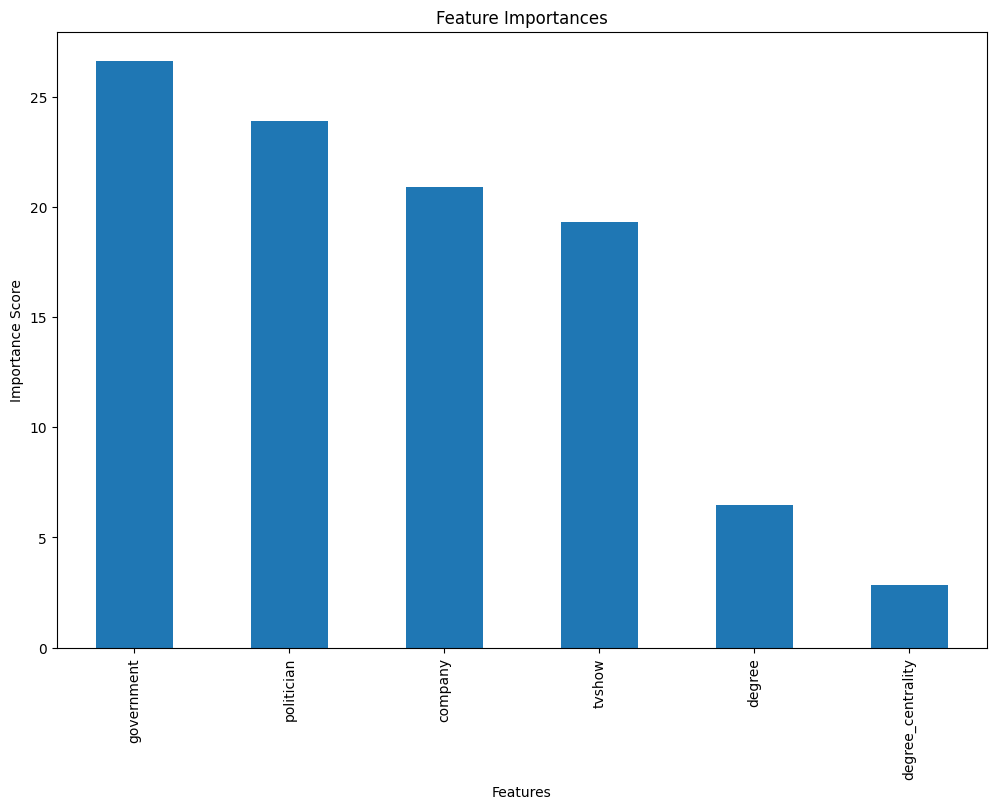

In [ ]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a pandas series to hold the importances
importance_series = pd.Series(feature_importances, index=features)

# Sort the feature importances by descending order
importance_sorted = importance_series.sort_values(ascending=False)

# Plot the feature importances
plt.figure(figsize=(12,8))
importance_sorted.plot(kind='bar')
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


Testing CatBoost with both Node Info as well as Neighbor Info

In [ ]:
#Create catboost model to predict the page_type using Degree, politician, company, tvshow, government
features = keyword_column_names + ['degree', 'government', 'politician', 'company', 'tvshow']

target = 'page_type'
X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Create the CatBoost classifier model
model = CatBoostClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred=model.predict(X_test)

Learning rate set to 0.091688
0:	learn: 1.1845482	total: 28.4ms	remaining: 28.4s
1:	learn: 1.0400073	total: 63.8ms	remaining: 31.8s
2:	learn: 0.9272209	total: 94.9ms	remaining: 31.5s
3:	learn: 0.8345071	total: 126ms	remaining: 31.4s
4:	learn: 0.7590873	total: 158ms	remaining: 31.4s
5:	learn: 0.6916371	total: 192ms	remaining: 31.9s
6:	learn: 0.6366906	total: 226ms	remaining: 32s
7:	learn: 0.5906685	total: 257ms	remaining: 31.8s
8:	learn: 0.5475295	total: 289ms	remaining: 31.9s
9:	learn: 0.5093271	total: 322ms	remaining: 31.9s
10:	learn: 0.4773568	total: 354ms	remaining: 31.8s
11:	learn: 0.4466993	total: 387ms	remaining: 31.8s
12:	learn: 0.4197557	total: 424ms	remaining: 32.2s
13:	learn: 0.3965409	total: 459ms	remaining: 32.3s
14:	learn: 0.3750528	total: 495ms	remaining: 32.5s
15:	learn: 0.3555407	total: 530ms	remaining: 32.6s
16:	learn: 0.3388427	total: 560ms	remaining: 32.4s
17:	learn: 0.3229967	total: 591ms	remaining: 32.3s
18:	learn: 0.3091666	total: 626ms	remaining: 32.3s
19:	learn:

In [ ]:
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9568313306631063
Confusion Matrix:
[[1301   35   19    3]
 [  35 1081    1    8]
 [  30    2 1285   23]
 [   6    4   28  633]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      1358
           1       0.96      0.96      0.96      1125
           2       0.96      0.96      0.96      1340
           3       0.95      0.94      0.95       671

    accuracy                           0.96      4494
   macro avg       0.96      0.96      0.96      4494
weighted avg       0.96      0.96      0.96      4494



## XGBoost

In [ ]:

#Create catboost model to predict the page_type using Degree, politician, company, tvshow, government
features = keyword_column_names + ['degree', 'government', 'politician', 'company', 'tvshow']

target = 'page_type'
X_train, X_test, y_train, y_test = train_test_split(final[features], final[target], test_size=0.2, random_state=42)

# Create the CatBoost classifier model
model = XGBClassifier()

# Fit the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)

y_pred=model.predict(X_test)

In [ ]:
print(accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

0.9559412550066756
Confusion Matrix:
[[1296   36   22    4]
 [  34 1085    1    5]
 [  32    2 1282   24]
 [   8    3   27  633]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1358
           1       0.96      0.96      0.96      1125
           2       0.96      0.96      0.96      1340
           3       0.95      0.94      0.95       671

    accuracy                           0.96      4494
   macro avg       0.96      0.95      0.96      4494
weighted avg       0.96      0.96      0.96      4494

